In [1]:
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
sin_schedule = np.linspace(0,2*np.pi*365-1/24*2*np.pi,365*24)
sin_schedule = -np.cos(sin_schedule)/2 + 0.5
schedules = np.stack([sin_schedule]*3).reshape(1,3,8760)

In [4]:
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
climate = extract(epw)

In [5]:
config = {
    "FacadeMass": 1,
    "RoofMass": 1,
    # "FacadeRValue": 4.88,
    # "RoofRValue": 4.88,
    # "SlabRValue": 4.88,
    "FacadeRValue": 1/0.4,
    "RoofRValue": 1/0.4,
    "SlabRValue": 1/0.4,
    "WindowShgc": 0.75,
    # "WindowUValue": 4.0,
    "WindowUValue": 2.0,
    "PeopleDensity": 0.025,
    "EquipmentPowerDensity": 5,
    "LightingPowerDensity": 10,
    "cop_heating": 1,
    "cop_cooling": 1,
    "HeatingSetpoint": 20,
    "CoolingSetpoint": 24,
    "VentilationMode": 1,
    "VentilationPerArea": 0.1/1000.0,
    "VentilationPerPerson": 2/1000.0,
    "EconomizerSettings": 0,
    "RecoverySettings": 0,
    "Infiltration": 0.0005,
    "template_idx": 0,
    "width": 3,
}
for i in range(12):
    config[f"shading_{i}"] = 0


In [6]:
perim_depths = [
    4.095575,
    4.290137,
    4.408696,
    3.867961,
    3.620988,
    4.243456,
    3.689587,
    3.551904,
    4.257538,
]
core_depths = [
    2.218851,
    1.453104,
    5.868895,
    0.313062,
    0.410147,
    3.067807,
    0.137619,
    0.775869,
    3.161792,
]
wwrs = [
    0.650813,
    0.206954,
    0.269906,
    0.725964,
    0.445224,
    0.384431,
    0.175211,
    0.789002,
    0.149327,
]
floors = [
    5,
    1,
    5,
    9,
    3,
    3,
    9,
    10,
    4,
]
heights = [
    3.354491,
    3.68949,
    4.159956,
    3.255392,
    3.970585,
    4.175988,
    4.77392,
    3.177442,
    4.481805,
]
footprint_areas = [
    710.10828,
    825.091115,
    1750.233351,
    490.922978,
    325.012711,
    1043.521907,
    350.25917,
    393.238916,
    1071.712731,
]
edge_weights = [
    [
        0.309881,
        0.200701,
        0.337301,
        0.152116,
    ],
    [
        0.096303,
        0.394535,
        0.108905,
        0.400256,
    ],
    [
        0.233931,
        0.284764,
        0.182907,
        0.298397,
    ],
    [
        0.127686,
        0.39669,
        0.048764,
        0.42686,
    ],
    [
        0.27105,
        0.174376,
        0.397359,
        0.157215,
    ],
    [
        0.27626,
        0.143801,
        0.392585,
        0.187354,
    ],
    [
        0.324614,
        0.147728,
        0.428012,
        0.099645,
    ],
    [
        0.074575,
        0.325632,
        0.32606,
        0.273733,
    ],
    [
        0.351093,
        0.184552,
        0.320761,
        0.143595,
    ],
]
orientations = [
    [
        2.472593,
        4.173047,
        5.77786,
        1.228807,
    ],
    [
        5.578455,
        1.030895,
        2.404381,
        4.201959,
    ],
    [
        4.772124,
        0.179418,
        1.547621,
        3.142135,
    ],
    [
        3.438789,
        4.91128,
        6.271531,
        1.58263,
    ],
    [
        5.657799,
        0.804997,
        2.643121,
        4.765805,
    ],
    [
        5.946189,
        0.985587,
        2.727859,
        4.815627,
    ],
    [
        3.212803,
        4.52586,
        0.221309,
        2.299934,
    ],
    [
        1.404783,
        3.563814,
        5.577763,
        1.437168,
    ],
    [
        1.847755,
        3.874944,
        5.08575,
        0.628994,
    ],
]


In [7]:

gfas = np.array(footprint_areas) * np.array(floors)
total_area = np.sum(gfas)
bldg_weights = gfas / total_area
n_buildings = len(wwrs)
sbs = []
for i in range(n_buildings):
    building_id = i
    wwr = wwrs[i]
    height = heights[i]
    perim_depth = perim_depths[i]
    core_depth = core_depths[i]
    footprint_area = footprint_areas[i]
    bldg_config = config.copy()
    bldg_weight = bldg_weights[i]
    bldg_config["building_id"] = building_id
    bldg_config["footprint_area"] = footprint_area
    bldg_config["wwr"] = wwr
    bldg_config["height"] = height
    bldg_config["perim_depth"] = perim_depth
    bldg_config["core_depth"] = core_depth
    bldg_config["bldg_weight"] = bldg_weight
    n_floors = floors[i]
    edge_weight = edge_weights[i]
    orientation = orientations[i]
    for weight, orient in zip(edge_weight, orientation):
        bldg_edge_config = bldg_config.copy()
        bldg_edge_config["edge_weight"] = weight
        bldg_edge_config["orientation"] = orient
        if n_floors == 1:
            bldg_edge_config["roof_2_footprint"] = 1
            bldg_edge_config["ground_2_footprint"] = 1
            bldg_edge_config["floor_weight"] = 1
            sbs.append(bldg_edge_config)
        elif n_floors == 2:
            bottom_config = bldg_edge_config.copy()
            top_config = bldg_edge_config.copy()
            bottom_config["ground_2_footprint"] = 1
            bottom_config["roof_2_footprint"] = 0
            top_config["ground_2_footprint"] = 0
            top_config["roof_2_footprint"] = 1
            bottom_config["floor_weight"] = 0.5
            top_config["floor_weight"] = 0.5
            sbs.append(bottom_config)
            sbs.append(top_config)
        else:
            bottom_config = bldg_edge_config.copy()
            middle_config = bldg_edge_config.copy()
            top_config = bldg_edge_config.copy()
            bottom_config["ground_2_footprint"] = 1
            bottom_config["roof_2_footprint"] = 0
            middle_config["ground_2_footprint"] = 0
            middle_config["roof_2_footprint"] = 0
            top_config["ground_2_footprint"] = 0
            top_config["roof_2_footprint"] = 1
            bottom_config["floor_weight"] = 1 / (n_floors)
            middle_config["floor_weight"] = (n_floors - 2) / (n_floors)
            top_config["floor_weight"] = 1 / (n_floors)
            sbs.append(bottom_config)
            sbs.append(middle_config)
            sbs.append(top_config)


features = pd.DataFrame(data=sbs)
features["weight"] = features["floor_weight"] * features["edge_weight"]
features["final_weight"] = features["weight"] * features["bldg_weight"]
features["core_weight"] = features["core_depth"] / (features["core_depth"] + features["perim_depth"])
features["perim_weight"] = features["perim_depth"] / (features["core_depth"] + features["perim_depth"])
shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=features,schedules=schedules, climate=climate,apply_cops=False, batch_size=32,)
zone_averaged = shoebox_results["Perimeter"] * features["perim_weight"].values.reshape(-1,1) + shoebox_results["Core"] * features["core_weight"].values.reshape(-1,1)
bldg_weighted = zone_averaged * features["final_weight"].values.reshape(-1,1)
bldg_weighted = bldg_weighted.sum(axis=0)

You are using a CUDA device ('NVIDIA RTX A5500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:02<00:00,  1.26it/s]

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting DataLoader 0: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


In [11]:
true_heating = [
    9.176773,
    6.865547,
    4.953202,
    1.313302,
    0.083836,
    0.000353,
    0,
    0,
    0.001402,
    0.404244,
    2.428034,
    5.691333,
]
true_cooling = [
    3.206026,
    3.824774,
    5.523106,
    8.618209,
    12.299401,
    20.06626,
    25.911303,
    24.886419,
    17.06723,
    8.816122,
    5.466594,
    2.59844,
]

C:\Users\szvsw\AppData\Local\Temp\ipykernel_20004\2850093922.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(
C:\Users\szvsw\AppData\Local\Temp\ipykernel_20004\2850093922.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(


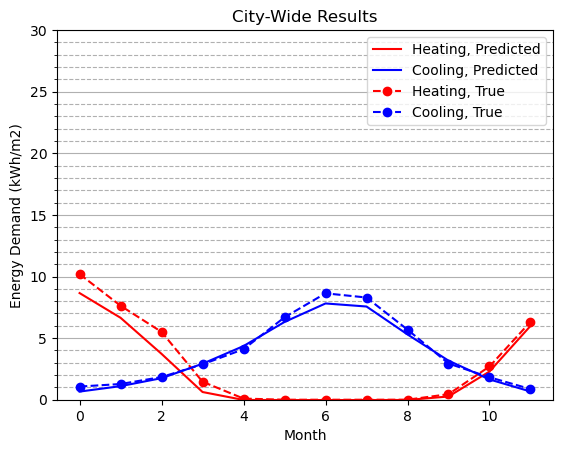

In [17]:
cop_heating = 0.9
cop_cooling = 3
import matplotlib.pyplot as plt
plt.figure()
plt.plot(
    bldg_weighted["Heating"].values/cop_heating, color="red", label="Heating, Predicted"
)
plt.plot(
    bldg_weighted["Cooling"].values/cop_cooling, color="blue", label="Cooling, Predicted"
)
plt.plot(
    np.array(true_heating)/cop_heating,"-o",linestyle="dashed", color="red", label="Heating, True"
)
plt.plot(
    np.array(true_cooling)/cop_cooling,"-o", color="blue",  linestyle="dashed",label="Cooling, True"
)
# add minor gridlines for every 1 y axis value
from matplotlib.ticker import MultipleLocator
ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.legend()
plt.title("City-Wide Results")
plt.xlabel("Month")
plt.ylabel("Energy Demand (kWh/m2)")
plt.ylim(0,30)
# plt.grid(axis="y", which="both")
plt.grid(axis="y", which="minor", linestyle="--")
plt.grid(axis="y", which="major", )


Text(0, 0.5, 'Energy Demand (kWh/m2)')

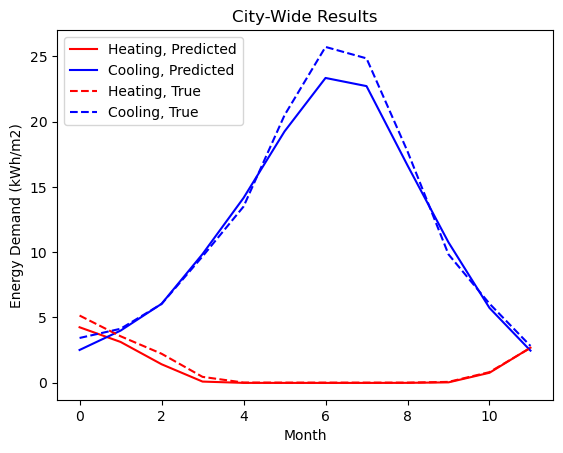

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(
    bldg_weighted["Heating"].values, color="red", label="Heating, Predicted"
)
plt.plot(
    bldg_weighted["Cooling"].values, color="blue", label="Cooling, Predicted"
)
plt.plot(
    true_heating, color="red", linestyle="--", label="Heating, True"
)
plt.plot(
    true_cooling, color="blue", linestyle="--", label="Cooling, True"
)
plt.legend()
plt.title("City-Wide Results")
plt.xlabel("Month")
plt.ylabel("Energy Demand (kWh/m2)")

In [ ]:
# shoebox_results = shoebox_results.set_index("box_name")
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

colors = {
    "bottom_south":"green",
    "middle_south": "green",
    "top_south": "green",
    "bottom_east":"blue",
    "middle_east": "blue",
    "top_east": "blue",
    "bottom_north":"yellow",
    "middle_north": "yellow",
    "top_north": "yellow",
    "bottom_west":"purple",
    "middle_west": "purple",
    "top_west": "purple",
}
fig,axs = plt.subplots(2,2,figsize=(10,8))
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]

for i in range(12):
    axs[0].plot(shoebox_results["Perimeter"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[1].plot(shoebox_results["Perimeter"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[2].plot(shoebox_results["Core"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[3].plot(shoebox_results["Core"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])


# axs[0].set_ylim([0,80])
# axs[1].set_ylim([0,5])
axs[0].yaxis.set_major_locator(MultipleLocator(5))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
axs[3].yaxis.set_major_locator(MultipleLocator(1))

axs[0].grid(axis="y",which="major")
axs[1].grid(axis="y",which="major")
axs[2].grid(axis="y",which="major")
axs[3].grid(axis="y",which="major")

axs[0].set_title("Perim Cooling")
axs[1].set_title("Perim Heating")
axs[2].set_title("Core Cooling")
axs[3].set_title("Core Heating")
plt.legend()
fig.tight_layout()

fig = plt.figure()
plt.plot(shoebox_results["Perimeter"]["Cooling"].mean(axis=0).values,"-o",color="blue",label="Perimeter Cooling Mean")
plt.plot(shoebox_results["Perimeter"]["Heating"].mean(axis=0).values,"-o",color="red",label="Perimeter Heating Mean")
plt.plot(shoebox_results["Core"]["Cooling"].mean(axis=0).values,"-o",color="lightblue",label="Core Cooling Mean",)
plt.plot(shoebox_results["Core"]["Heating"].mean(axis=0).values,"-o",color="pink",label="Core Heating Mean",)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.legend()
plt.grid(axis="y",which="major")